# **Stroke Predictor**


## **Importing data**


---
Doing all necessary setup. Initializing the dataframe.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

#import dataset as a pandas dataframe
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

#import data for table joins
gender = pd.read_csv("gender.csv")
married = pd.read_csv("married.csv")
residence = pd.read_csv("residence.csv")
smoked = pd.read_csv("smoked.csv")
work = pd.read_csv("work.csv")

Then I drop all irrelevant columns and print out some general data about the dataset.

In [2]:
# get rid of unimportant columns
df = df.drop(columns=['id'])

#printing the data types of each feature
print(df.dtypes)

#displays what is left
df.describe().transpose()

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Then I use table joins to enumerate any column with strings (objects)

In [3]:
#using inner table joins, enumerate the columns that use strings. This will add the enumerated columns
df = pd.merge(df,gender,how = "inner",on="gender")
df = pd.merge(df,married,how = "inner",on="ever_married")
df = pd.merge(df,residence, how ="inner",on="Residence_type")
df = pd.merge(df,smoked,how = "inner", on="smoking_status")
df = pd.merge(df,work,how = "inner",on="work_type")


#leave only enumerated columns, original ones are not important anymore
df.drop(columns=['gender', "ever_married", "Residence_type", "smoking_status", "work_type"], inplace=True)

#check to make sure everything looks right
df.head()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_value,maried_value,residence_value,smoking_value,work_value
0,67.0,0,1,228.69,36.6,1,1.0,2.0,1.0,2.0,1.0
1,81.0,0,0,186.21,29.0,1,1.0,2.0,1.0,2.0,1.0
2,71.0,0,0,102.87,27.2,1,1.0,2.0,1.0,2.0,1.0
3,78.0,1,0,75.32,NaN,1,1.0,2.0,1.0,2.0,1.0
4,78.0,0,0,237.75,NaN,1,1.0,2.0,1.0,2.0,1.0


In [4]:
#verifty every column is an number
print(df.dtypes)

age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
gender_value         float64
maried_value         float64
residence_value      float64
smoking_value        float64
work_value           float64
dtype: object


## **Exploratory Data Analysis**

Graphing the target feature and the features with missing data to check for biases.
<br><br>
#### **Null and Duplicated Values**
Shows amount of NaN's in the bmi column.




In [5]:
# amount of usuable data in the bmi 
hf = df.loc[np.isnan(df['bmi'])]
print(len(hf.index))

201


Shows the amount of unuseable data in the smoking column.

In [6]:
# a smoking value of 1 means it was unknown if the person smoked or not, this is not very helpful to us.
hf = df.loc[df['smoking_value'] == 1]
print(len(hf.index))

1544


Shows the amount of time that for the same row the bmi and smoking value is missing


In [7]:
hf = hf.loc[np.isnan(hf['bmi'])]
print(len(hf.index))

61


This means that the number of unique rows with missing data is 201 + 1544 - 64 = 1681 rows. This would be very bad to delete because the dataset is only around 5000 rows.

In [8]:
#Checking for NaNs in each column, this does not include the unusable data in smoking ("Unknown = 1")
df.isna().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
stroke                 0
gender_value           0
maried_value           0
residence_value        0
smoking_value          0
work_value             0
dtype: int64

Shows the number of rows that are identical

In [9]:
print(df.duplicated().sum())



0


#### **Features with Missing Data**

These show the boxplots for the two columns with missing data.

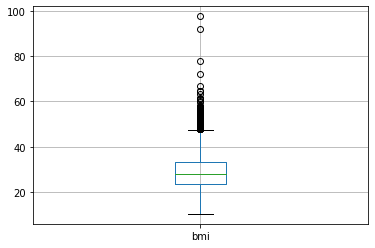

In [10]:
plot = df.boxplot(column=['bmi'])


We can see numerous outliers in one direction, thus the data is skewed.

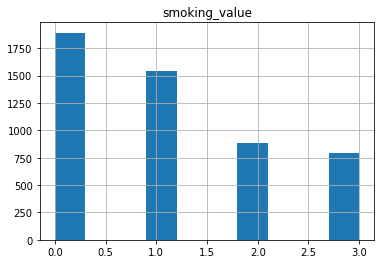

In [11]:
plot = df.hist(column=['smoking_value'])


This histogram also shows that the smoking column is also somewhat skewed.

#### **Target Feature**

Graphing the target feature for this analysis.

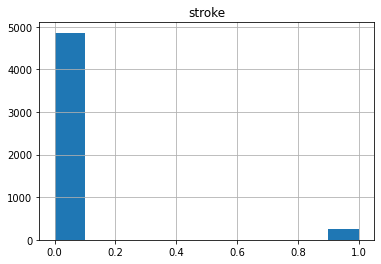

In [12]:
plot = df.hist(column=['stroke'])

The target feature is very skewed. This makes sense though as it is much easier to find people who have not had a stroke.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef1b9f1cd0>]],
      dtype=object)

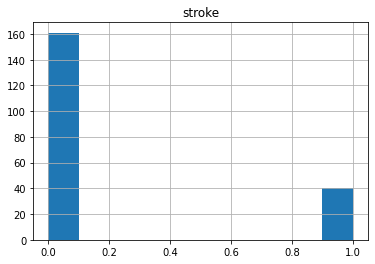

In [13]:
hf = df.loc[np.isnan(df['bmi'])]
hf.hist(column='stroke')


This is a graph of the distribution of missing values for the bmi column. Of course much more of the missing data is going to come from people who have not had a stroke because thats who the majority of the sample was. But, looking at the data in terms of a percentage of people sampled, the missing values seem to be random.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef1b9b2a60>]],
      dtype=object)

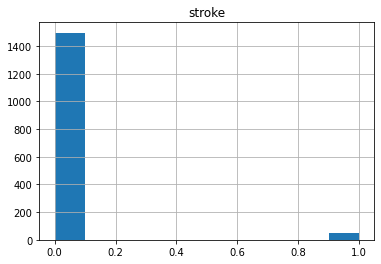

In [14]:
hf = df.loc[df['smoking_value'] == 1]
hf.hist(column='stroke')

This is a graph of the distribution of missing values for the bmi column. The distribution of missing values is mostly random for the same explanation as above.

##**Feature Engineering**

In [15]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_value,maried_value,residence_value,smoking_value,work_value
0,67.0,0,1,228.69,36.6,1,1.0,2.0,1.0,2.0,1.0
1,81.0,0,0,186.21,29.0,1,1.0,2.0,1.0,2.0,1.0
2,71.0,0,0,102.87,27.2,1,1.0,2.0,1.0,2.0,1.0
3,78.0,1,0,75.32,NaN,1,1.0,2.0,1.0,2.0,1.0
4,78.0,0,0,237.75,NaN,1,1.0,2.0,1.0,2.0,1.0


In the Exploratory Data Analysis section the graphs show that the data is missing at random. 

Since it is MAR, I wanted to use either the mean, median, or mode. As the data is skewed, (Exploratory Data Analysis) and is all numerical, I decided to use the median for imputation.

In [16]:
#replaces every NaN with the median
df['bmi'] = df['bmi'].replace(np.nan, df['bmi'].median())
#replaces every value equal to one (unknown smoking status) with the median
df['smoking_value'] = df['smoking_value'].apply(lambda x: df['smoking_value'].median() if x == 1.0 else x)
#verify NaN's turned into a number
df.head()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_value,maried_value,residence_value,smoking_value,work_value
0,67.0,0,1,228.69,36.6,1,1.0,2.0,1.0,2.0,1.0
1,81.0,0,0,186.21,29.0,1,1.0,2.0,1.0,2.0,1.0
2,71.0,0,0,102.87,27.2,1,1.0,2.0,1.0,2.0,1.0
3,78.0,1,0,75.32,28.1,1,1.0,2.0,1.0,2.0,1.0
4,78.0,0,0,237.75,28.1,1,1.0,2.0,1.0,2.0,1.0


In [17]:
#show data after all changes
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00
gender_value,5110.0,1.586301,0.492941,1.00,1.000,2.000,2.00,3.00
maried_value,5110.0,1.656164,0.475034,1.00,1.000,2.000,2.00,2.00
residence_value,5110.0,1.491977,0.499985,1.00,1.000,1.000,2.00,2.00
smoking_value,5110.0,1.111742,1.071819,0.00,0.000,1.000,2.00,3.00


The data now looks good and useable, but it needs to be normalized (all values between 0 and 1).

In [18]:
#makes it easy to separate the target from everything else
target = ['stroke']
predictors = list(set(list(df.columns))-set(target))
#normalize data by dividing all values in a column by the max of that column
df[predictors] = df[predictors]/df[predictors].max()

Now I want to do one last check to make sure that all of the features look right and the counts are still the same if missing values are removed.

In [19]:
#Removes missing values
df = df.dropna()
#Use count column to verify
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,5110.0,0.527154,0.275764,0.000976,0.304878,0.548780,0.743902,1.0
hypertension,5110.0,0.097456,0.296607,0.000000,0.000000,0.000000,0.000000,1.0
heart_disease,5110.0,0.054012,0.226063,0.000000,0.000000,0.000000,0.000000,1.0
avg_glucose_level,5110.0,0.390622,0.166643,0.202841,0.284261,0.338136,0.419850,1.0
bmi,5110.0,0.295718,0.078889,0.105533,0.243852,0.287910,0.336066,1.0
stroke,5110.0,0.048728,0.215320,0.000000,0.000000,0.000000,0.000000,1.0
gender_value,5110.0,0.528767,0.164314,0.333333,0.333333,0.666667,0.666667,1.0
maried_value,5110.0,0.828082,0.237517,0.500000,0.500000,1.000000,1.000000,1.0
residence_value,5110.0,0.745988,0.249992,0.500000,0.500000,0.500000,1.000000,1.0
smoking_value,5110.0,0.370581,0.357273,0.000000,0.000000,0.333333,0.666667,1.0


Shows the numbers of duplicates after transformation

In [20]:
print(df.duplicated().sum())

0


## **Modeling**

Now that all necessary preliminary steps have been taken, it is now time to split the data into training and testing.

In [21]:
#changes the dataframe into two numpy arrays
X = df[predictors].values
y = df[target].values
#Change y from a row-vector to a column array
y = np.ravel(y)

#split x and y arrays into training and testing, 30% of data goes to testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=40)


To evaluate each model I am using the classification report. This gives some important calculations with the most important being the accuracy and it is very readable. I am also using the confusing matrix because it is very simple and visual, and the numbers in the confusion matrix are how the statistics in the classification report are calculated.

#### **K Nearest Neighbor**
It is now time to test out some models, with the first one being KNN.

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1460
           1       0.33      0.03      0.05        73

    accuracy                           0.95      1533
   macro avg       0.64      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



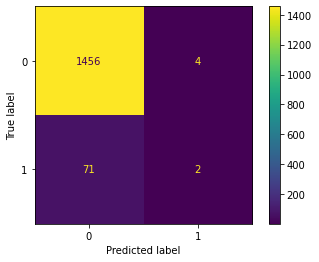

In [22]:
#import the model 
from sklearn.neighbors import KNeighborsClassifier
#initialize the model
neigh = KNeighborsClassifier()
#fits model to the training data
neigh.fit(X_train, y_train)
#Use the model to predict on new test data
predict_test = neigh.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

#shows the results of predictions of training data
matrix = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print(classification_report(y_test, predict_test))

#### **Random Forest Classifier** 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1460
           1       0.00      0.00      0.00        73

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.91      0.95      0.93      1533



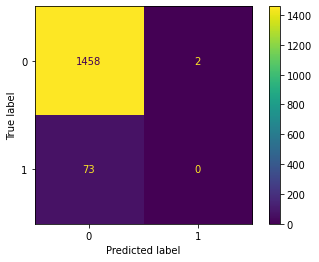

In [23]:
#import the model
from sklearn.ensemble import RandomForestClassifier
#initialize the model
rfc = RandomForestClassifier();
#fits model to the training data
rfc.fit(X_train, y_train)
#Use the model to predict on new test data
predict_test = rfc.predict(X_test)

#shows the results of predictions of training data
matrix = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print(classification_report(y_test, predict_test))

#### **Logistic Regression**

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1460
           1       1.00      0.00      0.00        73

    accuracy                           0.95      1533
   macro avg       0.98      0.50      0.49      1533
weighted avg       0.95      0.95      0.93      1533



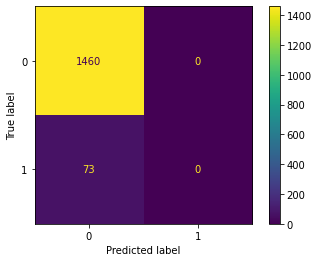

In [24]:
#import the model
from sklearn.linear_model import LogisticRegression
#initialize the model
lr = LogisticRegression(random_state=0);
#fits model to the training data
lr.fit(X_train, y_train)
#Use the model to predict on new test data
predict_test = lr.predict(X_test)

#shows the results of predictions of training data
matrix = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print(classification_report(y_test, predict_test,zero_division=1))

In [25]:
total = matrix[0][1] + matrix[0][0] + matrix[1][0] + matrix[1][1]
orig_tp = matrix[0][0]
orig_tn = matrix[1][1]
orig_fp = matrix[1][0]
orig_fn = matrix[0][1]
orig_accuracy = (matrix[0][0] + matrix[1][1]) / total

#### **Multi-layer Perceptron**


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1460
           1       1.00      0.00      0.00        73

    accuracy                           0.95      1533
   macro avg       0.98      0.50      0.49      1533
weighted avg       0.95      0.95      0.93      1533



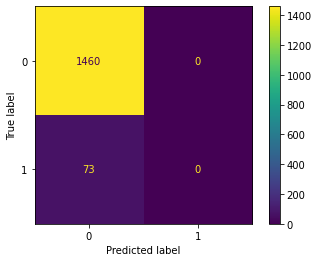

In [26]:
#import the model
from sklearn.neural_network import MLPClassifier
#initialize the model
nodes = len(df.columns)
model = MLPClassifier(hidden_layer_sizes=(nodes,nodes,nodes), activation='relu', solver='sgd', max_iter=200)
#fits model to the training data
model.fit(X_train,y_train)
#use the model to predict on new test data
predict_test = model.predict(X_test)

#shows the results of predictions of training data
matrix = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print(classification_report(y_test, predict_test,zero_division=1))


#### **Improving Accuracy**

The MLP and Logistic Regression were tied for most accurate, so I will chose Logistic Regression to attempt to optimize for more accuracy. First I will check what features the model found to be most important and least important from the random forest classifier.

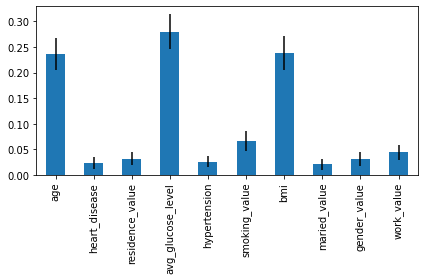

In [27]:
#use function to find importances
importances= rfc.feature_importances_
#organize into individual features, matches each column title to an importance
forest_importances = pd.Series(importances, index=df[predictors].columns)
#setup graph and plot results
fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances.plot.bar(yerr=std,ax=ax)
fig.tight_layout()

As one might predict, age, glucose level, and bmi are by far the three most predictive features. Since the rest are all pretty much on the same level, I don't want to drop them cause then I would be getting rid of a lot of features.

In [28]:
#increase importance of predictive features
df['age'] = df['age'] * 2
df['avg_glucose_level'] = df['avg_glucose_level'] * 2
df['bmi'] = df['bmi'] * 2

In [29]:
#same process we took earlier

predictors = list(set(list(df.columns))-set(target))
#changes the dataframe into two numpy arrays
X = df[predictors].values
y = df[target].values
#Change y from a row-vector to a column array
y = np.ravel(y)
#split x and y arrays into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=40)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1460
           1       1.00      0.00      0.00        73

    accuracy                           0.95      1533
   macro avg       0.98      0.50      0.49      1533
weighted avg       0.95      0.95      0.93      1533



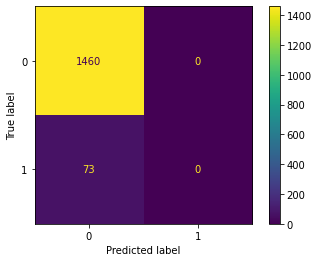

In [30]:
#initialize the model
lr = LogisticRegression(random_state=0,solver='liblinear');
#fits model to the training data
lr.fit(X_train, y_train)
#Use the model to predict on new test data
predict_test = lr.predict(X_test)

#shows the results of predictions of training data
matrix = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print(classification_report(y_test, predict_test,zero_division=1))

In [31]:
total = matrix[0][1] + matrix[0][0] + matrix[1][0] + matrix[1][1]
new_accuracy = (matrix[0][0] + matrix[1][1]) / total
print("Accuracy of new model: ", new_accuracy) 
print("Accuracy of original model: " , orig_accuracy)
print("Difference in accuracy: ", new_accuracy - orig_accuracy)
print("Difference between true positives: ", matrix[0][0] - orig_tp)
print("Difference between true negatives: ", matrix[1][1] - orig_tn)
print("Difference between fasle positives: ", matrix[1][0] - orig_fp)
print("Difference between false negatives: ", matrix[0][1] - orig_fn)

Accuracy of new model:  0.9523809523809523
Accuracy of original model:  0.9523809523809523
Difference in accuracy:  0.0
Difference between true positives:  0
Difference between true negatives:  0
Difference between fasle positives:  0
Difference between false negatives:  0


Unfortunately the optimization did not help. This is probably caused by a small dataset. Since the dataset was small, the models had fewer cases to learn from, which caused them to fit almost exactly to their training data (overfitting).